### This notebook demonstrate the conversion of Keras model  to MDF


In [192]:
# importing MDF libraries

import numpy as np
from modeci_mdf.utils import simple_connect
from modeci_mdf.mdf import *
from modeci_mdf.execution_engine import EvaluableGraph
import graph_scheduler


In [193]:
# importing tensorflow library
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras



In [194]:
# fetching out the helper functions from the Keras_MDF script
from Keras_MDF import *

In [195]:
# printing out the layers in the keras model

new_model = tf.keras.models.load_model("model.h5")
for x in new_model.layers:
    print(x.name)



dense
dense_1
dense_2
dense_3


In [196]:
# selective layers to extract
layers_to_extract = [ "dense", "dense_1", "dense_2"]

In [197]:
# getting the weights and activation of layer

params, activations = get_weights_and_activation(layers_to_extract, new_model)


In [198]:
# creating the model and graph from init_model_with_graph

mod, mod_graph = init_model_with_graph("keras_to_MDF", "Keras_to_MDF_graph")

In [199]:
#checking the input shape of the first dense layer of the keras model
new_model.layers[1].input_shape

(None, 16)

In [200]:
# defining the target vector

input = np.array(([1,0,1,1], [1,0,0,1], [1,0,1,0], [1,0,0,0]), dtype=float)


In [201]:
# create input node for the mdf model

input_node = create_input_node("input_node", input)

# append the input node to the graph

mod_graph.nodes.append(input_node)



### Create First Dense Node of the model

In [202]:
# get weights and bias for the first dense node
weights = params["dense"]["weights"]
bias = params["dense"]["bias"]

# create first dense node of the model
dense_node = create_dense_node("dense_node", weights, bias)

#append the dense node to the graph
mod_graph.nodes.append(dense_node)


### Create First Activation Node for the model

In [203]:
#create activation on the first dense node
activation_node = create_activation_node("activation_node",  activations[0])

#append the activation node to the graph
mod_graph.nodes.append(activation_node)



### Create Second Dense Node

In [204]:
# get weights and bias for the first dense node
weights_1 = params["dense_1"]["weights"]
bias_1= params["dense_1"]["bias"]

#create second dense noe
dense1_node = create_dense_node("dense1_node", weights_1, bias_1)

#append second dense node to the graph
mod_graph.nodes.append(dense1_node)

### Create Second activation Node

In [205]:
#create activation on the second dense node
activation1_node = create_activation_node("activation1_node",  activations[1])

#append the second activation node to the graph
mod_graph.nodes.append(activation1_node)



### Create the third Dense Node

In [206]:
# get weights and bias for the first dense node
weights_2 = params["dense_2"]["weights"]
bias_2 = params["dense_2"]["bias"]

#create the third dense node
dense2_node = create_dense_node("dense2_node", weights_2, bias_2)

#append the third dense node to the graph
mod_graph.nodes.append(dense2_node)

### Create Third Activation Node

In [207]:
#create actiuvation on the third dense node
activation2_node = create_activation_node("activation2_node",  activations[2])

#append the activation to the node
mod_graph.nodes.append(activation2_node)


### Create connections between the Nodes 


In [208]:
e1 = simple_connect(input_node, dense_node, mod_graph)
e2 = simple_connect(dense_node, activation_node, mod_graph)
e3 = simple_connect(activation_node, dense1_node, mod_graph)
e4 = simple_connect(dense1_node, activation1_node, mod_graph)
e5 = simple_connect(activation1_node, dense2_node, mod_graph)
e6 = simple_connect(dense2_node, activation2_node, mod_graph)

### Generate Graph Image of the Model

Converting MDF graph: Keras_to_MDF_graph to graphviz (level: 1, format: png)
    Node: input_node
    Node: dense_node
    Node: activation_node
    Node: dense1_node
    Node: activation1_node
    Node: dense2_node
    Node: activation2_node
    Edge: edge_input_node_dense_node connects input_node to dense_node
    Edge: edge_dense_node_activation_node connects dense_node to activation_node
    Edge: edge_activation_node_dense1_node connects activation_node to dense1_node
    Edge: edge_dense1_node_activation1_node connects dense1_node to activation1_node
    Edge: edge_activation1_node_dense2_node connects activation1_node to dense2_node
    Edge: edge_dense2_node_activation2_node connects dense2_node to activation2_node
Written graph image to: keras_to_MDF.png


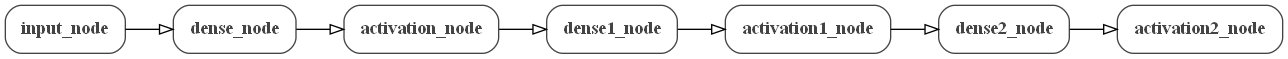

In [209]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=1,
        filename_root="keras_to_MDF",
        is_horizontal=True
    )

from IPython.display import Image
Image(filename="Keras_to_MDF.png")


### Evaluating the model

In [210]:
eg = EvaluableGraph(mod_graph, verbose=False)

# evaluating the model 
eg.evaluate()


Init graph: Keras_to_MDF_graph
Evaluating graph: Keras_to_MDF_graph, root nodes: ['input_node'], with array format numpy


In [211]:
# get mdf prediction

mdf_prediction = eg.enodes["activation2_node"].evaluable_outputs["activation2_node_out"].curr_value

In [212]:
# mdf prediction
mdf_prediction = mdf_prediction.round()

In [213]:
mdf_pred = np.argmax(mdf_prediction, axis= 1)
mdf_pred

array([1, 0, 1, 0], dtype=int64)

In [220]:
keras_prediction = new_model.predict(input_value)

1/1 [==============================] - 0s 41ms/step


In [221]:
keras_prediction.round()

array([[1.],
       [0.],
       [0.],
       [1.]], dtype=float32)